# Segmentazione Strategica della Clientela: un Progetto di Consulenza Data-Driven
Autore: ***Valerio Lapiello***

Data: 28 Settembre 2025

## Sommario

1. [Executive Summary](#summary)
2. [Obiettivo del Progetto e Dati](#obiettivo)
3. [Analisi Esplorativa dei Dati (EDA)](#eda)
4. [Metodologia di Segmentazione](#metodologia)
5. [Risultati: Mappatura e Profilazione dei Segmenti](#risultati)
6. [Analisi Investigativa: Perché i Nuovi Clienti Non Tornano?](#investigazione)
7. [Conclusioni e Raccomandazioni Strategiche](#conclusioni)
8. [Limiti dell'Analisi e Sviluppi Futuri](#limiti)

## 1. Executive Summary <a id='summary'></a>

Il presente studio è stato commissionato per analizzare un anno di dati transazionali di una pizzeria al fine di segmentarne la clientela e identificare opportunità di crescita strategica. Attraverso tecniche di machine learning non supervisionato (clustering HDBSCAN) applicate a metriche comportamentali ingegnerizzate, è stata creata una mappa dettagliata del mercato, superando una visione basata sui soli dati di vendita aggregati.

**Risultati Chiave**: L'analisi ha identificato **4 macro-segmenti strategici**:
1.  Un **"Nucleo Mainstream"** (54% dei clienti), che rappresenta la base di clienti occasionali.
2.  Un segmento di **"Clienti Fedeli"** (25%), di altissimo valore grazie alla loro elevata frequenza d'acquisto (alto CLV).
3.  Un critico segmento di **"Clienti a Rischio Abbandono"** (9%), composto da clienti che non tornano dopo la prima visita.
4.  Un gruppo di **"Outlier"** (11%) con comportamenti anomali.

L'indagine approfondita sui "Clienti a Rischio" ha rivelato che le cause dell'abbandono non sono univoche, ma legate a due problematiche distinte: una potenziale **esperienza negativa con i prodotti entry-level** per i clienti feriali a basso budget e una generale **debolezza dell'esperienza-cliente durante il weekend**.

**Raccomandazioni Strategiche Prioritarie**:
* **Proteggere i Clienti Fedeli** attraverso l'introduzione di un programma fedeltà per consolidare la loro routine d'acquisto.
* **Intervenire sui Clienti a Rischio** con una duplice azione:
    * **Rivedere l'offerta entry-level del menu** per garantire un'esperienza qualitativa positiva al primo contatto.
    * **Analizzare e potenziare l'operatività del business nel weekend** per trasformare una debolezza in un'opportunità di crescita.
* **Aumentare la Profittabilità del Mainstream** tramite strategie di upselling a basso impatto (es. menu combo).

Questo approccio segmentato permette di passare da strategie di marketing generiche ad azioni mirate, con un potenziale significativo di aumento della retention e della profittabilità.

In [1]:
# ==================================
# SEZIONE 1: SETUP E IMPORT LIBRERIE
# ==================================

# Importazione delle librerie fondamentali
import pandas as pd
import numpy as np
import warnings

# Importazione delle librerie per la visualizzazione
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Importazione dei modelli e delle funzioni di machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import trustworthiness
import hdbscan
import umap.umap_ as umap

# --- Configurazioni Globali ---
# Soppressione dei FutureWarning per mantenere l'output pulito
warnings.filterwarnings("ignore", category=FutureWarning)

# Impostazione di uno stile grafico consistente per tutto il report
sns.set_theme(style="whitegrid")

# Imposta il formato di visualizzazione per i numeri decimali (float)
# a due cifre dopo la virgola per l'intero notebook.
pd.options.display.float_format = '{:.2f}'.format

# Stampa di conferma
print("Librerie e configurazioni caricate con successo.")

Librerie e configurazioni caricate con successo.


## 2. Obiettivo del Progetto e Dati <a id='obiettivo'></a>

### 2.1 Obiettivo di business
Il presente report risponde a un mandato di consulenza per una pizzeria fittizia, con l'obiettivo di analizzare un anno di dati transazionali per superare una visione aggregata delle vendite e ottenere una comprensione profonda e segmentata della propria clientela. L'analisi si propone di rispondere ad alcune domande strategiche fondamentali per la crescita del business:
- È possibile identificare gruppi di clienti omogenei con comportamenti e preferenze distinti?
- Chi sono i **clienti di maggior valore** e quali caratteristiche li accomunano?
- Qual è il profilo del **cliente "medio"** e quali opportunità di crescita rappresenta?
- Esistono segmenti di clientela che mostrano un **rischio di abbandono** dopo la prima visita e quali sono le potenziali cause da investigare?

Attraverso un'analisi di **clustering** avanzata, questo report fornirà una mappa chiara della base clienti, trasformando i dati grezzi in insight azionabili.

### 2.2 Dati a Disposizione
L'analisi si basa su un dataset pubblico ("Maven Pizza Challenge") che simula un anno di operazioni. Il dataset è composto da quattro tabelle relazionali:
- `orders`: Informazioni su data e ora di ogni ordine.
- `order_details`: Dettagli su quali e quante pizze sono incluse in ogni ordine.
- `pizzas`: Informazioni su prezzo e tipo di ogni pizza.
- `pizza_types`: Dettagli su categoria e ingredienti di ogni tipo di pizza.

Nella fase iniziale di Data Engineering, queste tabelle sono state unificate in un unico dataset transazionale. Successivamente, per superare l'assenza di dati anagrafici, è stato applicato un approccio ibrido: sono state ingegnerizzate metriche di comportamento d'acquisto reali (es. frequenza, spesa) per clienti fittizi, le quali sono poi state utilizzate per generare attributi demografici sintetici (es. persona, fascia di reddito), creando una base dati ricca e adatta a un'analisi di segmentazione avanzata.

### 2.3 Preparazione e Ingegneria dei Dati: Dal Dato Grezzo all'Insight

Prima di ogni analisi, è fondamentale trasformare i dati grezzi in un formato pulito, strutturato e arricchito. Questa sezione illustra il processo di **Data Engineering** e **Feature Engineering** che ha costituito la base per l'intero progetto.

Il processo si è articolato in tre fasi principali:

**1. Unificazione dei Dati (Data Engineering)**
Le quattro tabelle sorgente (`orders`, `order_details`, `pizzas`, `pizza_types`) sono state unificate tramite una serie di operazioni di `merge`. Il risultato è un unico DataFrame transazionale in cui ogni riga rappresenta una singola pizza all'interno di un ordine specifico, arricchita con tutte le informazioni disponibili (prezzo, categoria, data, ora, ecc.).

**2. Creazione di Metriche Comportamentali (Feature Engineering)**
Il dataset originale mancava di un identificativo del cliente. Per superare questo limite, è stato creato un set di **"pseudo-clienti"** fittizi. Ipotizzando una base clienti plausibile di 8.000 utenti, ogni ordine unico è stato assegnato casualmente a un cliente (il processo è stato reso riproducibile tramite l'impostazione di un `random_state`).
Questa operazione ha permesso di aggregare i dati a livello di singolo cliente e di calcolare un set di **metriche comportamentali reali e misurabili**:
* **Spesa Totale e Media**: L'impatto economico di ogni cliente.
* **Frequenza d'Acquisto**: Il livello di lealtà e abitudine.
* **Preferenze di Categoria**: Le tipologie di pizza più scelte.
* **Rapporto Weekend/Feriale**: Le abitudini di consumo temporali.
Il risultato di questa fase è un nuovo DataFrame, `customers_df`, che rappresenta la "carta d'identità" comportamentale di ogni cliente.

**3. Generazione di Attributi Demografici Sintetici (Feature Engineering)**
Per arricchire ulteriormente i profili e abilitare una segmentazione più profonda, sono stati ingegnerizzati degli attributi demografici sintetici (`persona`, `income_bracket`). Basandosi sulle metriche comportamentali reali, è stata definita una funzione con una logica a punteggio, utilizzando soglie dinamiche calcolate dai dati stessi (medie e quartili). Questo approccio **data-driven** assicura che i profili demografici, sebbene fittizi, siano logicamente coerenti con il comportamento d'acquisto osservato.

In [2]:
# -----------------------------------------------
# --- SEZIONE 2: Caricamento e Merge dei Dati ---
# -----------------------------------------------

# 1. Definizione dei percorsi dei file sorgente
path_orders = 'data/orders.csv'
path_details = 'data/order_details.csv'
path_pizzas = 'data/pizzas.csv'
path_types = 'data/pizza_types.csv'

# 2. Caricamento dei file CSV in DataFrame pandas
try:
    orders = pd.read_csv(path_orders)
    order_details = pd.read_csv(path_details)
    pizzas = pd.read_csv(path_pizzas)
    pizza_types = pd.read_csv(path_types, encoding='latin1')
    print("File sorgente caricati con successo.")
except FileNotFoundError as e:
    print(f"Errore: file non trovato. Verificare il percorso: {e.filename}")

# 3. Unione progressiva dei DataFrame per creare un dataset unico
# Unione di order_details con pizzas tramite 'pizza_id'
df = pd.merge(order_details, pizzas, on='pizza_id')
# Unione del risultato con orders tramite 'order_id'
df = pd.merge(df, orders, on='order_id')
# Unione finale con pizza_types tramite 'pizza_type_id'
df = pd.merge(df, pizza_types, on='pizza_type_id')

# 4. Visualizzazione delle prime righe del DataFrame finale per verifica
print("DataFrame unificato creato con successo. Di seguito un'anteprima:")
display(df.head())

File sorgente caricati con successo.
DataFrame unificato creato con successo. Di seguito un'anteprima:


,order_details_id,order_id,pizza_id,quantity,pizza_type_id,size,price,date,time,name,category,ingredients
0,1,1,hawaiian_m,1,hawaiian,M,13.25,01/01/2015,11:38:36,The Hawaiian Pizza,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese"
1,2,2,classic_dlx_m,1,classic_dlx,M,16.00,01/01/2015,11:57:40,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,..."
2,3,2,five_cheese_l,1,five_cheese,L,18.50,01/01/2015,11:57:40,The Five Cheese Pizza,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go..."
3,4,2,ital_supr_l,1,ital_supr,L,20.75,01/01/2015,11:57:40,The Italian Supreme Pizza,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni..."
4,5,2,mexicana_m,1,mexicana,M,16.00,01/01/2015,11:57:40,The Mexicana Pizza,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O..."


In [3]:
# ---------------------------------------------------------------------
# --- SEZIONE 2: Ingegneria dei Dati: Creazione dei Profili Cliente ---
# ---------------------------------------------------------------------

# 1. Preparazione delle Variabili Temporali
# Convertiamo le colonne testuali in formati data/ora per analisi temporali
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df['time'] = pd.to_timedelta(df['time'])
# Creiamo una colonna 'datetime' unificata
df['datetime'] = df['date'] + df['time']
# Estraiamo il giorno della settimana (Lunedì=0, Domenica=6)
df['day_of_week'] = df['datetime'].dt.dayofweek

# 2. Creazione di "Pseudo-Clienti" Sintetici
# Fissiamo un 'seed' per garantire la riproducibilità dell'analisi:
# chiunque esegua questo codice otterrà sempre gli stessi risultati.
np.random.seed(42)

# Identifichiamo tutti gli ordini unici
unique_orders = df['order_id'].unique()

# Stabiliamo un numero plausibile di clienti fittizi e li generiamo
NUM_CUSTOMERS = 8000
synthetic_customers = [f"cust_{i}" for i in range(1, NUM_CUSTOMERS + 1)]

# Assegniamo casualmente ogni ordine unico a un cliente fittizio
order_to_customer_map = {order_id: np.random.choice(synthetic_customers) for order_id in unique_orders}

# Creiamo la nuova colonna 'customer_id' nel DataFrame principale
df['customer_id'] = df['order_id'].map(order_to_customer_map)

# 3. Calcolo delle Metriche Comportamentali
# Calcoliamo il valore totale di ogni singolo ordine
order_price = df.groupby('order_id')['price'].sum().reset_index().rename(columns={'price': 'order_total_price'})
df = pd.merge(df, order_price, on='order_id')

# Creiamo un nuovo DataFrame 'customers_df' aggregando i dati per cliente
# per ottenere il profilo comportamentale di ciascuno.
customer_orders = df[['customer_id', 'order_id', 'order_total_price']].drop_duplicates()
avg_spend_per_customer = customer_orders.groupby('customer_id')['order_total_price'].mean()

customers_df = df.groupby('customer_id').agg(
    total_spend=('price', 'sum'),
    order_frequency=('order_id', 'nunique'),
    preferred_pizza_category=('category', lambda x: x.mode()[0]),
    weekend_shopper_ratio=('day_of_week', lambda x: (x >= 5).mean())
).reset_index()

# Uniamo la spesa media per ordine al DataFrame dei profili
customers_df = pd.merge(customers_df, avg_spend_per_customer.rename('avg_spend_per_order'), on='customer_id')

# 4. Visualizzazione del risultato finale
print("DataFrame 'customers_df' con le metriche comportamentali creato con successo:")
display(customers_df.head())

DataFrame 'customers_df' con le metriche comportamentali creato con successo:


,customer_id,total_spend,order_frequency,preferred_pizza_category,weekend_shopper_ratio,avg_spend_per_order
0,cust_10,98.25,4,Chicken,0.33,24.56
1,cust_1000,81.50,3,Classic,0.00,27.17
2,cust_1001,20.75,1,Supreme,0.00,20.75
3,cust_1002,41.25,3,Chicken,0.00,13.75
4,cust_1004,68.75,2,Chicken,0.00,34.38


In [4]:
# -------------------------------------------------------------------------
# --- SEZIONE 2: Ingegneria dei Dati: Generazione Attributi Demografici ---
# -------------------------------------------------------------------------

# 1. Calcolo delle Soglie Dinamiche
# Per rendere la logica robusta, calcoliamo le soglie decisionali (es. quartili, medie)
# direttamente dai dati. Questo assicura che le regole si adattino a qualsiasi dataset.
thresholds = {
    'q1_spend': customers_df['avg_spend_per_order'].quantile(0.25),
    'q3_spend': customers_df['avg_spend_per_order'].quantile(0.75),
    'mean_freq': customers_df['order_frequency'].mean(),
    'mean_spend': customers_df['avg_spend_per_order'].mean()
}

# 2. Definizione della Funzione di Assegnazione
# Questa funzione assegna una "persona" e una "fascia di reddito" a ogni cliente
# in base alle sue metriche di comportamento e alle soglie calcolate.
def assign_demographics(row, thresholds_dict):
    """Assegna attributi demografici basati sul comportamento d'acquisto."""
    
    # Assegnazione Fascia di Reddito in base alla spesa media per ordine
    if row['avg_spend_per_order'] > thresholds_dict['q3_spend']:
        income = 'High'
    elif row['avg_spend_per_order'] > thresholds_dict['q1_spend']:
        income = 'Medium'
    else:
        income = 'Low'
        
    # Assegnazione Persona con una logica a punteggio per maggiore flessibilità
    score = 0
    if row['order_frequency'] >= thresholds_dict['mean_freq']:
        score += 1
    if row['avg_spend_per_order'] > thresholds_dict['mean_spend']:
        score += 1
    if row['weekend_shopper_ratio'] >= 0.5:
        score += 1
    
    if score >= 2:
        persona = 'Family/Groups'
    # Regola specifica per identificare un segmento a basso coinvolgimento
    elif row['order_frequency'] <= 2 and row['avg_spend_per_order'] < 30:
        persona = 'Student/Professional'
    else:
        persona = 'Couple/Occasional'
        
    return persona, income

# 3. Applicazione della Funzione
# Applichiamo la funzione a ogni riga del DataFrame per creare le nuove colonne.
customers_df[['persona', 'income_bracket']] = customers_df.apply(
    lambda row: assign_demographics(row, thresholds), 
    axis=1, 
    result_type='expand'
)

# 4. Visualizzazione del Risultato
print("Attributi demografici sintetici aggiunti con successo al DataFrame dei clienti:")
display(customers_df.head())

Attributi demografici sintetici aggiunti con successo al DataFrame dei clienti:


,customer_id,total_spend,order_frequency,preferred_pizza_category,weekend_shopper_ratio,avg_spend_per_order,persona,income_bracket
0,cust_10,98.25,4,Chicken,0.33,24.56,Couple/Occasional,Low
1,cust_1000,81.50,3,Classic,0.00,27.17,Couple/Occasional,Medium
2,cust_1001,20.75,1,Supreme,0.00,20.75,Student/Professional,Low
3,cust_1002,41.25,3,Chicken,0.00,13.75,Couple/Occasional,Low
4,cust_1004,68.75,2,Chicken,0.00,34.38,Couple/Occasional,Medium


## 3. Analisi Esplorativa dei Dati <a id='eda'></a>

Prima di procedere con la modellazione, è stata condotta un'Analisi Esplorativa dei Dati (EDA) per comprendere i pattern fondamentali del business. L'EDA si è concentrata su due aree chiave: l'analisi temporale delle vendite e l'analisi delle performance dei prodotti.

### 3.1 Analisi Temporale: Il Ritmo del Business

L'analisi dei dati temporali ha rivelato un'attività dal ritmo stabile e prevedibile, caratterizzata da picchi di domanda ben definiti.

* **Andamento Mensile**: Le vendite mensili per l'anno in esame si sono dimostrate stabili, senza una chiara tendenza al rialzo o al ribasso. Si notano fluttuazioni, come un picco positivo a luglio e cali a febbraio e nel periodo autunnale. Sebbene questi pattern possano suggerire una stagionalità, è necessaria una serie storica più lunga per confermarlo con certezza.

* **Andamento Settimanale e Orario**: L'attività mostra un chiaro aumento degli ordini nella seconda parte della settimana, con un picco il Venerdì. Sorprendentemente, la Domenica risulta essere uno dei giorni più deboli, suggerendo una potenziale opportunità di mercato non sfruttata. A livello orario, si identificano due fasce di punta nette: il pranzo (12:00-14:00) e la cena (17:00-19:00).

Questi insight sono fondamentali per l'ottimizzazione della gestione del personale e delle scorte.

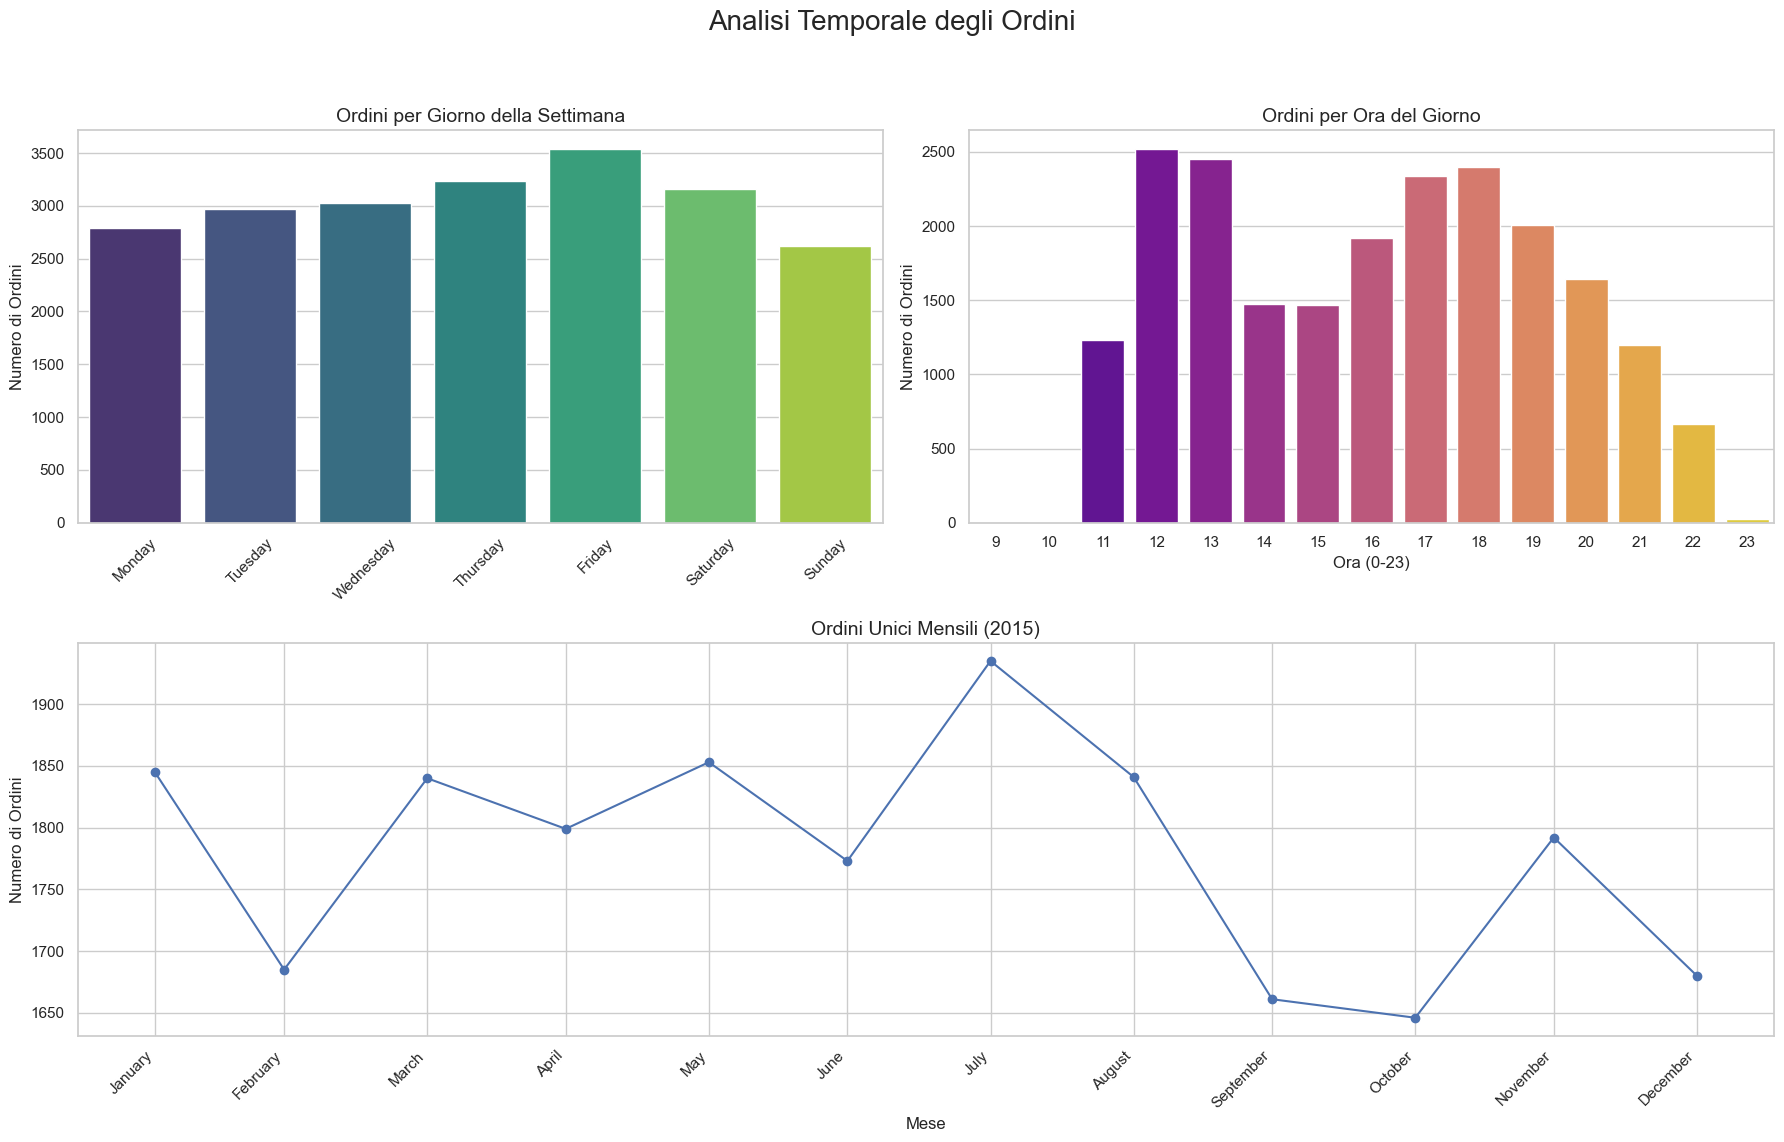

In [5]:
# -------------------------------------------
# --- SEZIONE 3: EDA -> Analisi Temporale ---
# -------------------------------------------

# 1. Preparazione delle colonne per l'analisi giornaliera e oraria
df['day_name'] = df['datetime'].dt.day_name()
df['hour'] = df['datetime'].dt.hour

# 2. Creazione della figura e della griglia personalizzata
fig = plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, figure=fig) # Creiamo una griglia 2x2

# Assegniamo gli assi: due grafici nella prima riga, uno che occupa tutta la seconda riga
ax1 = fig.add_subplot(gs[0, 0]) # Riga 0, Colonna 0
ax2 = fig.add_subplot(gs[0, 1]) # Riga 0, Colonna 1
ax3 = fig.add_subplot(gs[1, :])  # Riga 1, occupa tutte le colonne

fig.suptitle('Analisi Temporale degli Ordini', fontsize=20)

# Grafico 1: Ordini per Giorno della Settimana (in ax1)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(ax=ax1, data=df.drop_duplicates(subset=['order_id']), x='day_name', order=day_order, palette='viridis')
ax1.set_title('Ordini per Giorno della Settimana', fontsize=14)
ax1.set_xlabel('')
ax1.set_ylabel('Numero di Ordini')
ax1.tick_params(axis='x', rotation=45)

# Grafico 2: Ordini per Ora del Giorno (in ax2)
sns.countplot(ax=ax2, data=df.drop_duplicates(subset=['order_id']), x='hour', palette='plasma')
ax2.set_title('Ordini per Ora del Giorno', fontsize=14)
ax2.set_xlabel('Ora (0-23)')
ax2.set_ylabel('Numero di Ordini')

# Grafico 3: Andamento Mensile (in ax3)
orders_per_month = df.resample('M', on='datetime')['order_id'].nunique()
ax3.plot(orders_per_month.index, orders_per_month.values, marker='o', linestyle='-')
ax3.set_title('Ordini Unici Mensili (2015)', fontsize=14)
ax3.set_xlabel('Mese')
ax3.set_ylabel('Numero di Ordini')
# Formattiamo l'asse x per mostrare solo i nomi dei mesi
month_labels = orders_per_month.index.strftime('%B')
ax3.set_xticks(orders_per_month.index)
ax3.set_xticklabels(month_labels, rotation=45, ha='right')


plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 3.2 Analisi dei Prodotti: I "Cavalli di Battaglia" e i "Pesi Morti"

L'analisi delle vendite a livello di singolo prodotto ha permesso di identificare i bestseller che guidano il fatturato e i prodotti meno performanti che potrebbero rappresentare un'inefficienza operativa.

* **Categorie di Pizza**: La categoria "Classic" è nettamente la più popolare, costituendo il nucleo dell'offerta. Le altre categorie (Supreme, Veggie, Chicken) mostrano volumi di vendita comparabili tra loro. È interessante notare come la categoria "Chicken", pur essendo l'ultima per volumi totali, contenga alcuni dei prodotti singoli più venduti, indicando un alto potenziale in una nicchia specifica.

* **Performance dei Prodotti**: L'analisi ha evidenziato una chiara distinzione tra i prodotti di punta e quelli marginali. Mentre pizze come "The Classic Deluxe Pizza" e "The Barbecue Chicken Pizza" dominano le vendite, un prodotto in particolare, "The Brie Carre Pizza", risulta essere il meno venduto in assoluto, con volumi talmente bassi da metterne in discussione la permanenza nel menu.

Queste informazioni sono il punto di partenza per una futura razionalizzazione del menu e per strategie di marketing mirate.

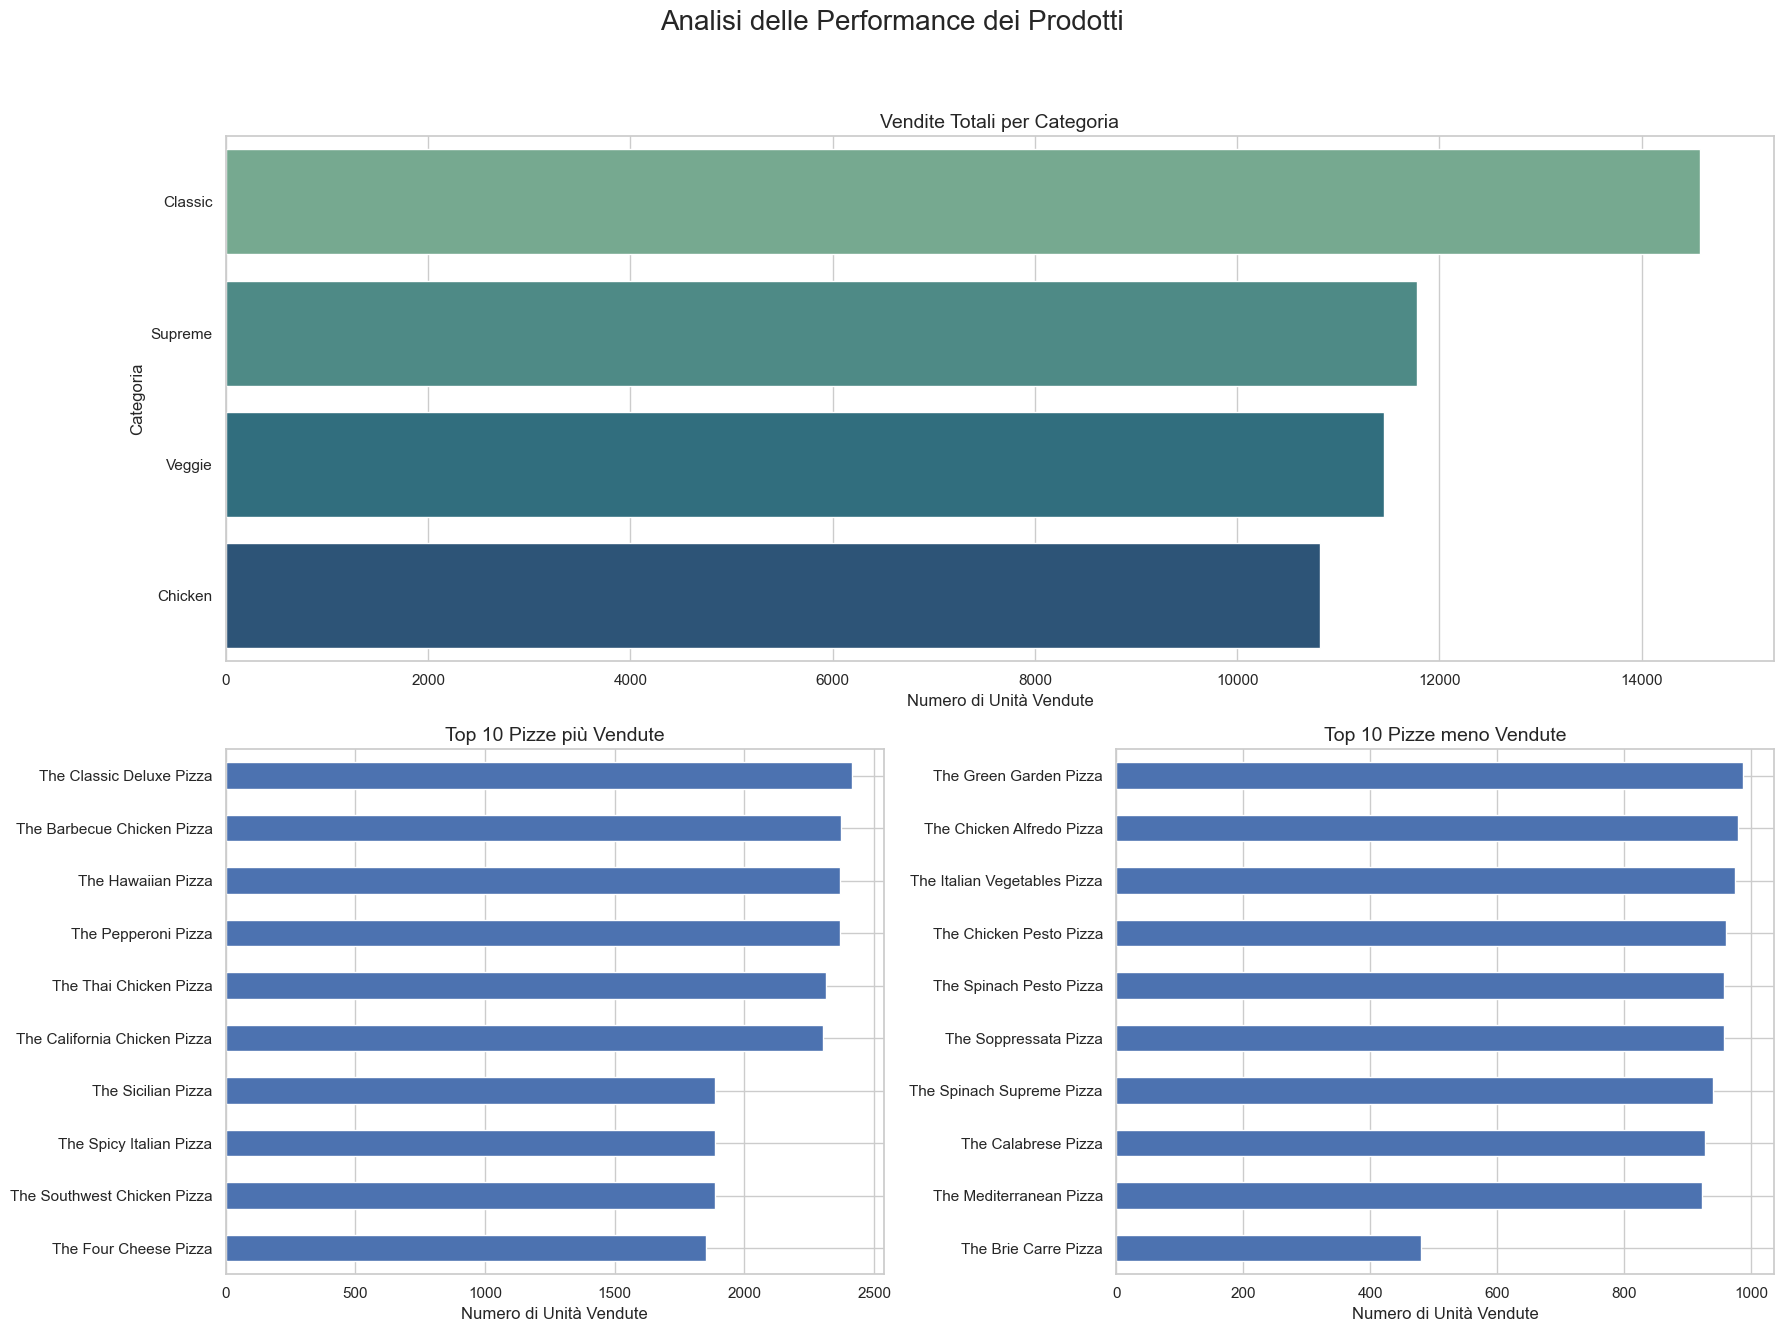

In [6]:
# ----------------------------------------------
# --- SEZIONE 3: EDA -> Analisi dei Prodotti ---
# ----------------------------------------------

# 1. Creazione della figura e della griglia personalizzata
fig = plt.figure(figsize=(18, 14))
gs = GridSpec(2, 2, figure=fig) # Creiamo una griglia 2x2

# Assegniamo gli assi: un grafico che occupa tutta la prima riga, due nella seconda
ax1 = fig.add_subplot(gs[0, :])  # Riga 0, occupa tutte le colonne
ax2 = fig.add_subplot(gs[1, 0])  # Riga 1, Colonna 0
ax3 = fig.add_subplot(gs[1, 1])  # Riga 1, Colonna 1

fig.suptitle('Analisi delle Performance dei Prodotti', fontsize=20)

# Grafico 1: Vendite per Categoria (in ax1)
sns.countplot(ax=ax1, data=df, y='category', order=df['category'].value_counts().index, palette='crest')
ax1.set_title('Vendite Totali per Categoria', fontsize=14)
ax1.set_xlabel('Numero di Unità Vendute')
ax1.set_ylabel('Categoria')

# Grafico 2: Top 10 Pizze più Vendute (in ax2)
df['name'].value_counts().nlargest(10).sort_values(ascending=True).plot(ax=ax2, kind='barh')
ax2.set_title('Top 10 Pizze più Vendute', fontsize=14)
ax2.set_xlabel('Numero di Unità Vendute')
ax2.set_ylabel('') # Rimuoviamo l'etichetta y per pulizia

# Grafico 3: Top 10 Pizze meno Vendute (in ax3)
df['name'].value_counts().nsmallest(10).sort_values(ascending=True).plot(ax=ax3, kind='barh')
ax3.set_title('Top 10 Pizze meno Vendute', fontsize=14)
ax3.set_xlabel('Numero di Unità Vendute')
ax3.set_ylabel('') # Rimuoviamo l'etichetta y per pulizia

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 4. Metodologia di Segmentazione <a id='metodologia'></a>

Per identificare i segmenti di clientela, è stato scelto un approccio basato sul **clustering**, una tecnica di machine learning non supervisionato che raggruppa i dati in base alla loro somiglianza. La scelta dell'algoritmo di clustering è stata guidata da un'analisi preliminare della struttura dei dati dei clienti (`customers_df`), al fine di selezionare il modello le cui assunzioni si adattassero meglio alle caratteristiche intrinseche del dataset.

### 4.1 Analisi della Struttura dei Dati dei Clienti

Prima di applicare qualsiasi modello, è fondamentale comprendere la distribuzione e la "forma" dei dati.

L'analisi delle distribuzioni delle quattro metriche comportamentali chiave attraverso dei boxplot rivela due caratteristiche importanti:
1.  **Asimmetria Positiva (Right-Skewed)**: Per tutte le metriche, la maggior parte dei clienti si concentra su valori bassi (poche visite, bassa spesa), con una lunga "coda" di valori più alti.
2.  **Presenza di Outlier**: Le metriche di spesa presentano un numero significativo di outlier, ovvero clienti con comportamenti estremi rispetto alla media.

Queste caratteristiche, in particolare la sensibilità agli outlier, sconsigliano l'uso di algoritmi basati sui centroidi come K-Means, che potrebbero produrre risultati distorti.

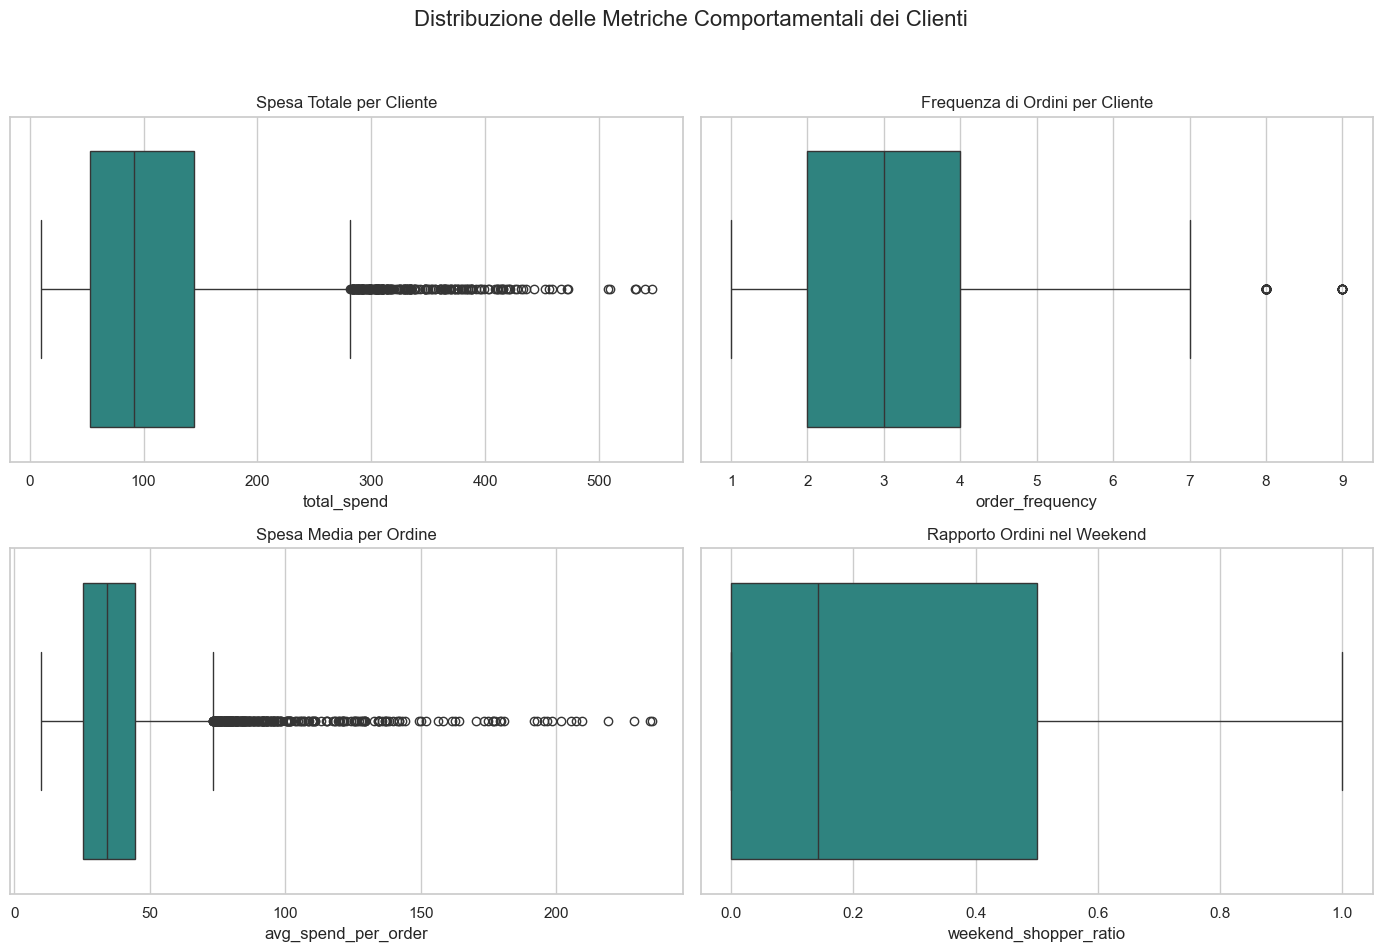

In [7]:
# ---------------------------------------------------------------------
# --- SEZIONE 4: Analisi delle Distribuzioni delle Metriche Cliente ---
# ---------------------------------------------------------------------

# Creazione della griglia di visualizzazione 2x2
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribuzione delle Metriche Comportamentali dei Clienti', fontsize=16)

# Boxplot per total_spend
sns.boxplot(ax=axes[0, 0], data=customers_df, x='total_spend', palette='viridis')
axes[0, 0].set_title('Spesa Totale per Cliente')

# Boxplot per order_frequency
sns.boxplot(ax=axes[0, 1], data=customers_df, x='order_frequency', palette='viridis')
axes[0, 1].set_title('Frequenza di Ordini per Cliente')

# Boxplot per avg_spend_per_order
sns.boxplot(ax=axes[1, 0], data=customers_df, x='avg_spend_per_order', palette='viridis')
axes[1, 0].set_title('Spesa Media per Ordine')

# Boxplot per weekend_shopper_ratio
sns.boxplot(ax=axes[1, 1], data=customers_df, x='weekend_shopper_ratio', palette='viridis')
axes[1, 1].set_title('Rapporto Ordini nel Weekend')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 4.2 Visualizzazione della "Forma" dei Dati e Scelta del Modello

Per visualizzare la forma multidimensionale dei dati in uno spazio 2D, sono state confrontate due tecniche di **riduzione della dimensionalità**: PCA (lineare) e UMAP (non lineare).

La visualizzazione ha mostrato che, mentre la PCA proietta i dati in una nuvola informe, **UMAP rivela una struttura interna complessa**, caratterizzata da cluster di forma non sferica e con densità variabili. Questa evidenza visiva, supportata anche da metriche quantitative di "affidabilità" della proiezione, conferma ulteriormente l'inadeguatezza di K-Means e indica la necessità di un modello basato sulla densità.

Di conseguenza, è stato scelto l'algoritmo **HDBSCAN**, in quanto è specificamente progettato per:
* Scoprire cluster di forma arbitraria.
* Gestire cluster con densità variabili.
* Isolare automaticamente gli outlier (rumore), una caratteristica fondamentale dato il nostro dataset.

C:\Users\valer\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


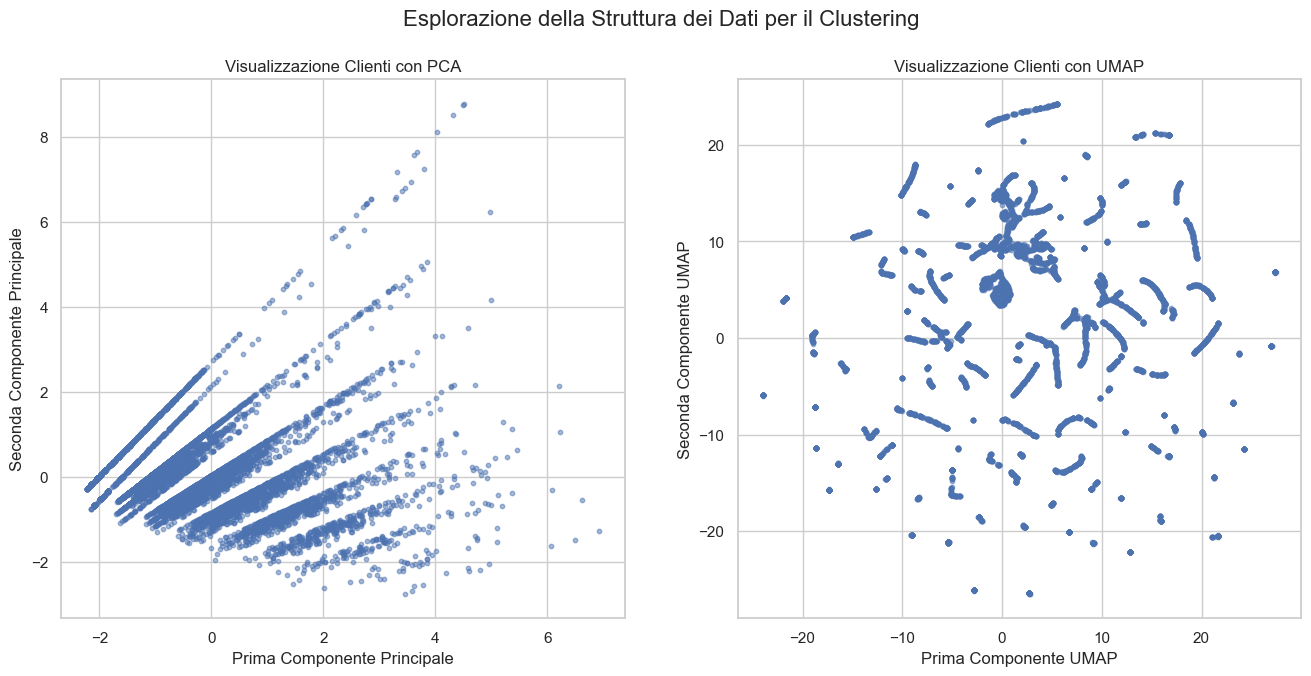

In [8]:
# -------------------------------------------------------------------------
# --- SEZIONE 4: Visualizzazione della Struttura dei Dati (PCA vs UMAP) ---
# -------------------------------------------------------------------------

# Standardizzazione dei dati (passaggio necessario per algoritmi basati sulla distanza)
features_for_clustering = ['total_spend', 'order_frequency', 'weekend_shopper_ratio', 'avg_spend_per_order']
customers_numerical = customers_df[features_for_clustering]
scaler = StandardScaler()
customers_scaled = scaler.fit_transform(customers_numerical)
customers_scaled_df = pd.DataFrame(customers_scaled, columns=features_for_clustering)

# 1. Riduzione con PCA
pca = PCA(n_components=2, random_state=42)
customers_pca = pca.fit_transform(customers_scaled_df)

# 2. Riduzione con UMAP
umap_reducer = umap.UMAP(n_components=2, random_state=42)
customers_umap = umap_reducer.fit_transform(customers_scaled_df)

# 3. Visualizzazione Comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Esplorazione della Struttura dei Dati per il Clustering', fontsize=16)

# Grafico PCA
ax1.scatter(customers_pca[:, 0], customers_pca[:, 1], s=10, alpha=0.5)
ax1.set_title('Visualizzazione Clienti con PCA')
ax1.set_xlabel('Prima Componente Principale')
ax1.set_ylabel('Seconda Componente Principale')

# Grafico UMAP
ax2.scatter(customers_umap[:, 0], customers_umap[:, 1], s=10, alpha=0.5)
ax2.set_title('Visualizzazione Clienti con UMAP')
ax2.set_xlabel('Prima Componente UMAP')
ax2.set_ylabel('Seconda Componente UMAP')

plt.show()

### 4.3 Ottimizzazione degli Iperparametri

HDBSCAN non richiede di specificare il numero di cluster, ma il suo comportamento è guidato da due iperparametri principali che ne definiscono la sensibilità e la granularità: `min_samples` e `min_cluster_size`.

* **`min_samples`**: Controlla la "tolleranza al rumore" dell'algoritmo. Per questa analisi, è stato impostato un valore fisso di **`min_samples=10`**. Questa scelta si basa sulla considerazione di dominio che un gruppo di 10 clienti rappresenta la più piccola nicchia con una potenziale significatività di business.

* **`min_cluster_size`**: Definisce la dimensione minima di un raggruppamento di punti per essere considerato un cluster. Mantenendo fisso `min_samples`, è stata condotta un'analisi di sensibilità su questo parametro per trovare il livello di segmentazione più stabile e significativo.

La scelta finale è ricaduta su **`min_cluster_size=150`**. Come mostra la tabella sottostante, questo valore rappresenta un punto di equilibrio in cui l'algoritmo identifica un numero di cluster stabile (12), consolidando i micro-cluster meno robusti e mantenendo una percentuale di rumore contenuta (~11%).

In [9]:
# -------------------------------------------------------
# --- SEZIONE 4: Ottimizzazione Iperparametro HDBSCAN ---
# -------------------------------------------------------

# Test di un range di valori per min_cluster_size per osservarne l'impatto
min_cluster_sizes = [15, 25, 50, 100, 150, 250, 400]
results = []

for size in min_cluster_sizes:
    clusterer = hdbscan.HDBSCAN(min_cluster_size=size,
                               min_samples=10)
    clusterer.fit(customers_scaled_df)
    labels = clusterer.labels_
    
    num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_percentage = (labels == -1).sum() / len(labels) * 100
    
    results.append({
        'min_cluster_size': size,
        'num_clusters': num_clusters,
        'noise_percentage': f"{noise_percentage:.2f}%"
    })

# Creazione di una tabella riassuntiva dei risultati
results_df = pd.DataFrame(results)
print("Risultati dell'analisi di sensibilità per min_cluster_size:")
display(results_df)

Risultati dell'analisi di sensibilità per min_cluster_size:


,min_cluster_size,num_clusters,noise_percentage
0,15,104,21.33%
1,25,58,16.72%
2,50,34,17.52%
3,100,23,11.38%
4,150,12,11.61%
5,250,9,6.11%
6,400,7,16.31%


## 5. Risultati: Mappatura e Profilazione dei Segmenti di Clientela <a id='risultati'></a>

L'applicazione del modello HDBSCAN sui dati comportamentali ha permesso di mappare la clientela in **12 cluster distinti**, di cui un gruppo di outlier. Questa sezione presenta una panoramica di questi segmenti, analizzandone le caratteristiche quantitative per comprenderne l'identità e il valore.

La mappa sottostante, basata sulla proiezione UMAP, visualizza la posizione e la forma dei cluster identificati, offrendo una prima visione della complessa struttura del mercato.

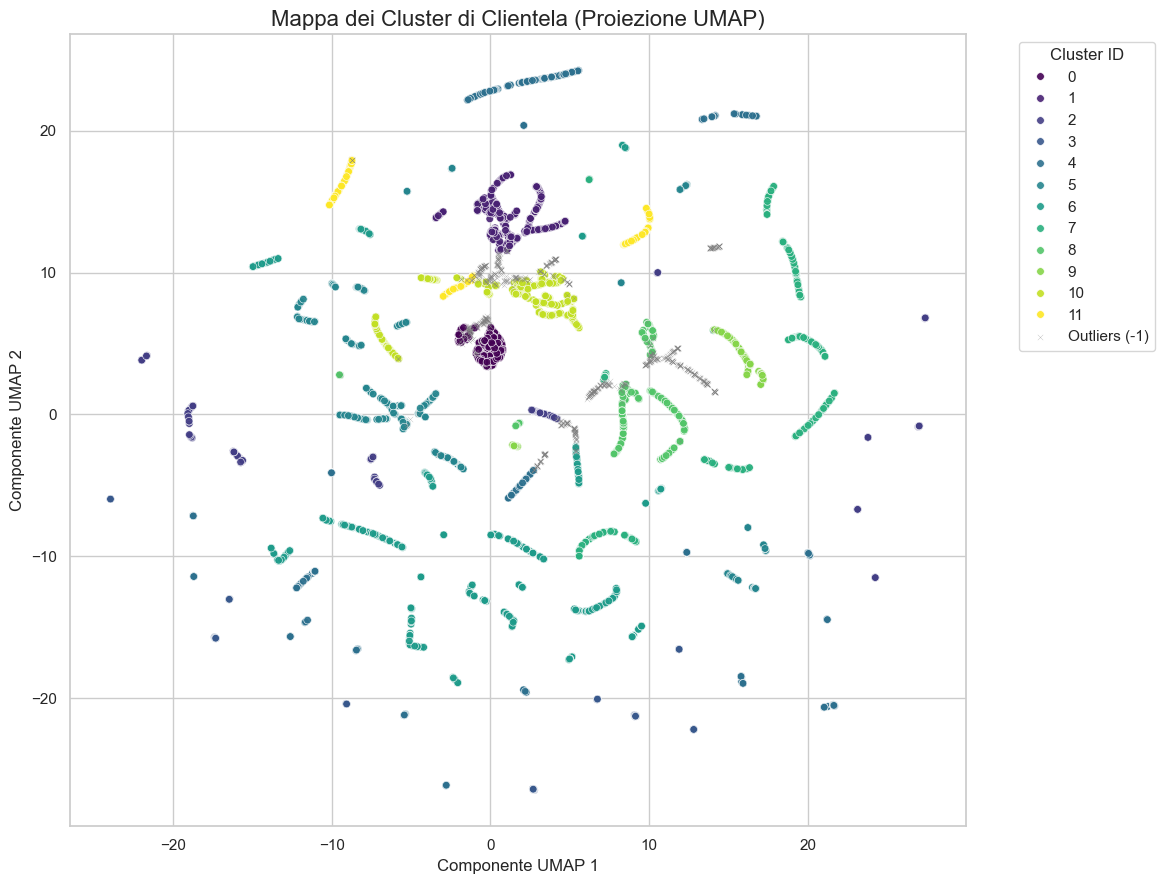

In [10]:
# ---------------------------------------------------------------------
# --- SEZIONE 5: Addestramento e Visualizzazione del Modello Finale ---
# ---------------------------------------------------------------------

# 1. Addestramento del modello HDBSCAN con i parametri scelti
final_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=150,
    min_samples=10,
    prediction_data=True
)
final_hdbscan.fit(customers_scaled_df)

# 2. Aggiunta delle etichette dei cluster al DataFrame
customers_df['hdbscan_cluster'] = final_hdbscan.labels_

# 3. Preparazione dei dati per la visualizzazione migliorata
clustered_points = customers_df[customers_df['hdbscan_cluster'] != -1]
outliers = customers_df[customers_df['hdbscan_cluster'] == -1]

umap_clustered = customers_umap[customers_df['hdbscan_cluster'] != -1]
umap_outliers = customers_umap[customers_df['hdbscan_cluster'] == -1]

# 4. Creazione della visualizzazione finale dei cluster
plt.figure(figsize=(14, 9))
sns.scatterplot(
    x=umap_clustered[:, 0], y=umap_clustered[:, 1],
    hue=clustered_points['hdbscan_cluster'],
    palette='viridis', s=30, alpha=0.9, legend='full'
)
sns.scatterplot(
    x=umap_outliers[:, 0], y=umap_outliers[:, 1],
    color='gray', marker='x', s=15, alpha=0.5, label='Outliers (-1)'
)

plt.title('Mappa dei Cluster di Clientela (Proiezione UMAP)', fontsize=16)
plt.xlabel('Componente UMAP 1')
plt.ylabel('Componente UMAP 2')
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### 5.1 Profilazione Comparativa dei Cluster

Per tradurre la mappa visiva in insight di business, è stata creata una "carta d'identità" numerica per ogni cluster. La heatmap sottostante è lo strumento di analisi principale: visualizza la **deviazione percentuale del comportamento mediano di ogni cluster rispetto alla mediana del cliente "tipico"**.

* Le **celle rosse** indicano un comportamento **significativamente superiore alla media** (es. clienti che spendono o visitano molto più del normale).
* Le **celle blu** indicano un comportamento **significativamente inferiore alla media**.
* Le **celle grigie** indicano un comportamento **in linea con la media**.

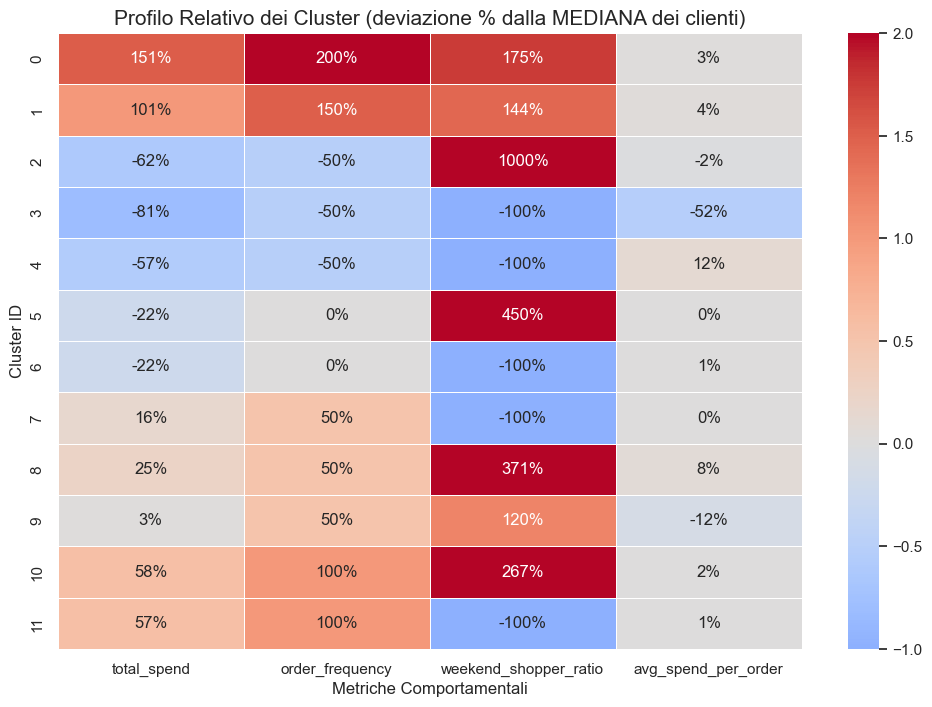

--- Profilo dei Cluster (Valori MEDIANI Assoluti) ---


,total_spend,order_frequency,weekend_shopper_ratio,avg_spend_per_order,cluster_size
hdbscan_cluster,,,,,
6,67.25,2.00,0.00,33.62,1062
5,66.50,2.00,0.50,33.25,805
4,37.25,1.00,0.00,37.25,743
7,99.75,3.00,0.00,33.25,651
10,135.20,4.00,0.33,33.80,617
1,172.60,5.00,0.22,34.52,580
8,107.25,3.00,0.43,35.75,527
2,32.50,1.00,1.00,32.50,397
0,215.55,6.00,0.25,34.19,360


In [11]:
# --- Profilazione dei Cluster: Heatmap e Tabella dei Valori Mediani ---

# 1. Calcolo dei Profili Mediani
# Si calcolano i valori mediani (più robusti agli outlier) per ogni metrica comportamentale e per ogni cluster.
cluster_profiles_median = customers_df[customers_df['hdbscan_cluster'] != -1].groupby('hdbscan_cluster').median(numeric_only=True)
cluster_profiles_median['cluster_size'] = customers_df[customers_df['hdbscan_cluster'] != -1]['hdbscan_cluster'].value_counts()

# 2. Calcolo della Mediana di Riferimento
# Si calcola la mediana generale della popolazione "non-outlier" per avere una baseline di confronto.
population_median = customers_df[customers_df['hdbscan_cluster'] != -1][features_for_clustering].median()

# 3. Calcolo dei Profili Relativi
# Si calcola la deviazione percentuale di ogni cluster rispetto alla mediana di riferimento.
relative_profiles_median = cluster_profiles_median[features_for_clustering].div(population_median, axis=1) - 1

# 4. Visualizzazione della Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    relative_profiles_median,
    annot=True,
    fmt='.0%', 
    cmap='coolwarm',
    linewidths=.5,
    center=0,  # Fissa il colore neutro (bianco) sul valore 0
    vmin=-1.0, # Imposta il limite inferiore della scala di colori a -100%
    vmax=2.0   # Imposta il limite superiore a +200% (valori superiori avranno lo stesso colore del massimo)
)
plt.title('Profilo Relativo dei Cluster (deviazione % dalla MEDIANA dei clienti)', fontsize=15)
plt.xlabel('Metriche Comportamentali')
plt.ylabel('Cluster ID')
plt.show()

# 5. Visualizzazione della Tabella dei Valori Assoluti
print("--- Profilo dei Cluster (Valori MEDIANI Assoluti) ---")
display(cluster_profiles_median.sort_values('cluster_size', ascending=False,))

### 5.2 Analisi e Identità dei Cluster

L'analisi dei profili numerici ci permette di dare un'identità precisa a ogni cluster, raggruppandoli in macro-segmenti preliminari basati sulle loro caratteristiche comportamentali.

#### **Il Nucleo Mainstream: I Clienti Occasionali**
Questi cluster rappresentano il cuore del business, clienti con una frequenza bassa o media, su cui si regge il volume d'affari quotidiano.

* **Cluster 6: "Il Pubblico Feriale" (14.3%)**: Clienti medi per spesa e frequenza, ma che consumano **esclusivamente nei giorni feriali**. Profilo tipico di lavoratori in pausa pranzo o studenti.
* **Cluster 5: "Gli Occasionali Flessibili" (10.9%)**: Il cliente occasionale standard, con un comportamento bilanciato tra settimana e weekend.
* **Cluster 7 & 8: Le Versioni "Premium" del Mainstream (8.8% & 7.1%)**: Clienti occasionali che si distinguono per una frequenza e/o una spesa per visita leggermente superiore alla media, mostrando un potenziale di crescita verso il segmento dei fedeli.
* **Cluster 9: "I Flessibili a Spesa Contenuta" (3.1%)**: Un piccolo gruppo a cavallo tra i segmenti, con una frequenza media ma una spesa per visita inferiore, probabilmente molto sensibile al prezzo.

#### **La Nicchia di Valore: I Clienti Fedeli**
Questi cluster, pur essendo numericamente inferiori, costituiscono il patrimonio più prezioso dell'azienda in termini di **Customer Lifetime Value (CLV)**, grazie alla loro altissima frequenza di acquisto.

* **Cluster 11: "Gli Affezionati Feriali" (4.0%)**: Clienti con una routine di acquisto consolidata durante la settimana.
* **Cluster 10, 1, 0: "La Scala della Fedeltà" (8.3%, 7.8%, 4.9%)**: Tre livelli crescenti di lealtà, che rappresentano i clienti più assidui in assoluto. La loro spesa per visita rimane stabile, indicando un comportamento di acquisto abitudinario e funzionale. Complessivamente, questo gruppo di super-fedeli costituisce oltre il **20%** della clientela.

#### **L'Area Critica: I Clienti a Rischio "Mono-Visita"**
Infine, l'analisi rivela un insieme consistente di cluster il cui tratto distintivo è aver effettuato **una sola visita**. Questi clienti, rappresentando quasi il **20% della base clienti**, costituiscono un'area ad alto rischio di abbandono.

* **Cluster 4: "I Mono-Visita Feriali" (10.0%)**: Il gruppo più numeroso di clienti di passaggio, con un comportamento di spesa nella media.
* **Cluster 2: "I Mono-Visita del Weekend" (5.4%)**: Un gruppo particolarmente preoccupante, in quanto la loro unica visita avviene in un'occasione di consumo tipicamente sociale e ad alto potenziale.
* **Cluster 3: "I Mono-Visita a Basso Budget" (3.9%)**: Clienti con una spesa molto contenuta, potenzialmente più sensibili a un'esperienza non ottimale.

Data l'importanza strategica di comprendere le cause di questo mancato ritorno, la sezione successiva sarà dedicata a un'**analisi investigativa approfondita** su questi tre specifici cluster di clientela a rischio.

## 6. Analisi Investigativa: Perché i Nuovi Clienti Non Tornano? <a id='investigazione'></a>

Dopo aver identificato un preoccupante segmento di "Clienti a Rischio Abbandono" (20% della clientela) caratterizzato da una singola visita, è stata condotta un'analisi investigativa mirata per comprenderne le possibili cause.

L'approccio ha previsto l'isolamento dei tre cluster "mono-visita" (4, 3 e 2) e un'analisi comparativa dei loro comportamenti d'acquisto specifici, confrontandoli con quelli del segmento dei "Clienti Fedeli", preso come riferimento del "comportamento ideale".

In [12]:
# ---------------------------------------------------------------
# --- SEZIONE 6: Analisi Investigativa: Preparazione dei Dati ---
# ---------------------------------------------------------------

# 1. Creazione del DataFrame di Indagine unendo le informazioni sui cluster
customer_info = customers_df[['customer_id', 'hdbscan_cluster', 'persona', 'income_bracket']]
investigation_df = pd.merge(df, customer_info, on='customer_id')

# 2. Isolamento dei gruppi di analisi
at_risk_clusters = [2, 3, 4]
loyal_clusters = [0, 1, 10, 11]

# Gruppo di Controllo
loyal_df = investigation_df[investigation_df['hdbscan_cluster'].isin(loyal_clusters)]

# Gruppi Sperimentali (analizzati separatamente)
risk_cluster_4_df = investigation_df[investigation_df['hdbscan_cluster'] == 4]
risk_cluster_2_df = investigation_df[investigation_df['hdbscan_cluster'] == 2]
risk_cluster_3_df = investigation_df[investigation_df['hdbscan_cluster'] == 3]

### 6.1 Indagine sul Cluster 4: "I Clienti di Passaggio"

L'analisi del cluster più numeroso tra quelli a rischio (10% del totale) rivela un profilo demografico sintetico molto chiaro: si tratta prevalentemente di clienti **"Couple/Occasional"** con una netta maggioranza nella fascia di **reddito "High"**.

Questa caratteristica, unita alla loro natura "mono-visita", rafforza l'ipotesi che si tratti di clienti di passaggio (es. turisti, lavoratori in trasferta) che, trovandosi in una situazione "una tantum", sono meno sensibili al prezzo.

In [13]:
# --- Statistiche Demografiche Cluster 4 ---
print("--- Profilo Demografico (Cluster 4) ---")
display(risk_cluster_4_df.describe(include=['object']))

--- Profilo Demografico (Cluster 4) ---


,pizza_id,pizza_type_id,size,name,category,ingredients,customer_id,day_name,persona,income_bracket
count,1840,1840,1840,1840,1840,1840,1840,1840,1840,1840
unique,91,32,5,32,4,32,743,5,2,3
top,big_meat_s,classic_dlx,L,The Classic Deluxe Pizza,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",cust_7945,Friday,Couple/Occasional,High
freq,74,102,729,102,552,102,5,454,1520,988


Le loro scelte d'acquisto (categoria, dimensione, orario) e le pizze specifiche ordinate non mostrano anomalie significative e sono largamente sovrapponibili a quelle della clientela generale.

**Conclusione per il Cluster 4**: La loro natura "mono-visita" non sembra legata a un'esperienza negativa, ma è più probabilmente una caratteristica intrinseca del loro profilo. Non rappresentano, quindi, un'area di intervento prioritaria.

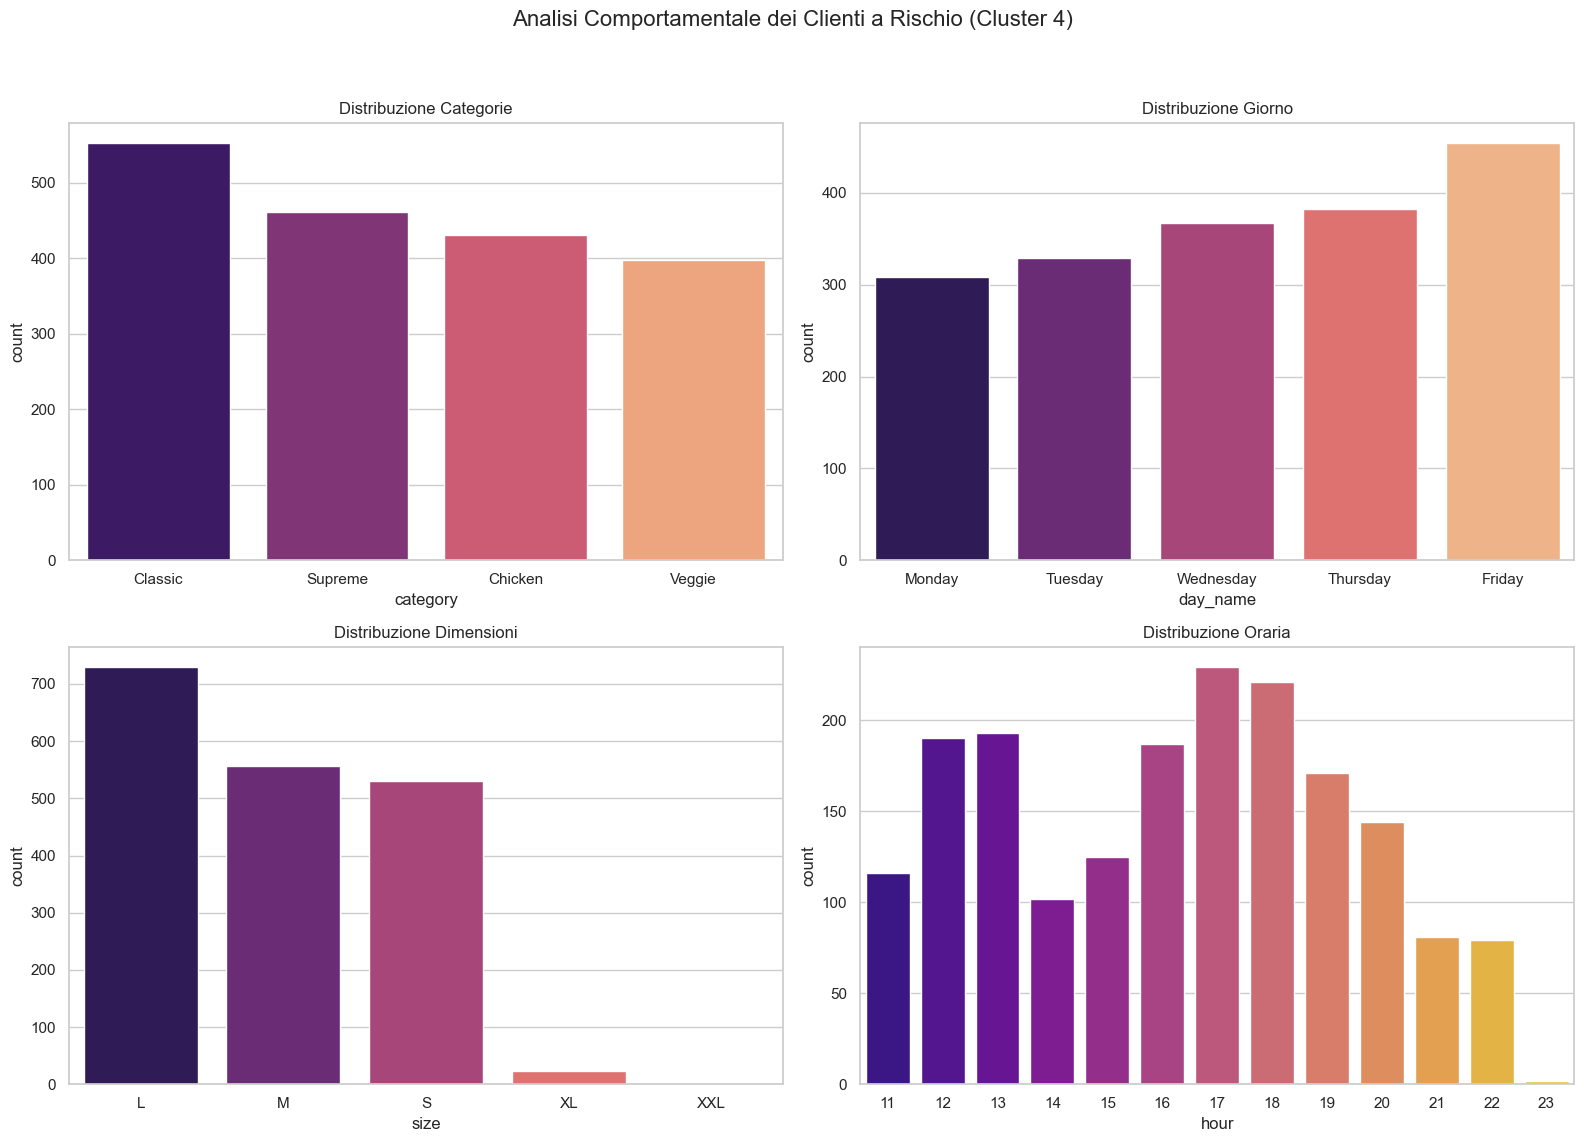

In [14]:
# ---------------------------------------------------------
# --- SEZIONE 6: Analisi Visiva Comportamento Cluster 4 ---
# ---------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Comportamentale dei Clienti a Rischio (Cluster 4)', fontsize=16)
# Categoria
sns.countplot(ax=axes[0, 0], data=risk_cluster_4_df, x='category', order=risk_cluster_4_df['category'].value_counts().index, palette='magma')
axes[0, 0].set_title('Distribuzione Categorie')
# Giorno
sns.countplot(ax=axes[0, 1], data=risk_cluster_4_df, x='day_name', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], palette='magma')
axes[0, 1].set_title('Distribuzione Giorno')
# Dimensione
sns.countplot(ax=axes[1, 0], data=risk_cluster_4_df, x='size', order=risk_cluster_4_df['size'].value_counts().index, palette='magma')
axes[1, 0].set_title('Distribuzione Dimensioni')
# Orario
sns.countplot(ax=axes[1, 1], data=risk_cluster_4_df, x='hour', palette='plasma')
axes[1, 1].set_title('Distribuzione Oraria')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 6.2 Indagine sul Cluster 3: La Scoperta del "Menu Entry-Level Problematico"

Il profilo del Cluster 3 è estremamente omogeneo: si tratta esclusivamente di clienti **"Student/Professional" a basso reddito**, con una netta preferenza per la fascia oraria del pranzo.

In [15]:
# --- Statistiche Demografiche Cluster 3 ---
print("--- Profilo Demografico (Cluster 3) ---")
display(risk_cluster_3_df.describe(include=['object']))

--- Profilo Demografico (Cluster 3) ---


,pizza_id,pizza_type_id,size,name,category,ingredients,customer_id,day_name,persona,income_bracket
count,289,289,289,289,289,289,289,289,289,289
unique,58,31,3,31,4,31,289,5,1,1
top,big_meat_s,pepperoni,M,The Pepperoni Pizza,Classic,"Mozzarella Cheese, Pepperoni",cust_7529,Thursday,Student/Professional,Low
freq,15,23,132,23,105,23,1,70,289,289


L'analisi delle loro scelte ha rivelato un **pattern allarmante**. A differenza degli altri segmenti, una porzione significativa di questo gruppo (**il 12.80%**) concentra i propri ordini su pizze che si collocano nella **fascia bassa della classifica di popolarità generale**. La tabella sottostante, che confronta le loro scelte con quelle dei clienti fedeli, evidenzia in rosso le pizze problematiche, tra cui spiccano "The Soppressata Pizza", "The Mediterranean Pizza" e "The Green Garden Pizza".

In [16]:
# --- Analisi Pizze Ordinate (Cluster 3 vs. Fedeli) ---
top_pizzas_cluster_3 = risk_cluster_3_df['name'].value_counts(normalize=True).nlargest(20) * 100
top_pizzas_loyal = loyal_df['name'].value_counts(normalize=True).nlargest(10) * 100
comparison_pizzas_c3_df = pd.DataFrame({'Clienti a Rischio (Cluster 3) %': top_pizzas_cluster_3, 'Clienti Fedeli %': top_pizzas_loyal}).fillna(0)
least_popular_pizzas = df['name'].value_counts().nsmallest(10).index
problematic_pizzas = comparison_pizzas_c3_df.index.intersection(least_popular_pizzas)
print("\n--- Confronto Top 20 Pizze Ordinate (Cluster 3 vs. Fedeli) ---")
display(comparison_pizzas_c3_df.style.apply(lambda s: ['background-color: #ffcccb' if s.name in problematic_pizzas else '' for i in s], axis=1))


--- Confronto Top 20 Pizze Ordinate (Cluster 3 vs. Fedeli) ---


,Clienti a Rischio (Cluster 3) %,Clienti Fedeli %
name,,
The Barbecue Chicken Pizza,3.806228,4.878837
The Big Meat Pizza,5.190311,0.000000
The Calabrese Pizza,2.076125,0.000000
The California Chicken Pizza,3.114187,4.792676
The Chicken Alfredo Pizza,3.114187,0.000000
The Classic Deluxe Pizza,7.266436,4.932687
The Five Cheese Pizza,3.460208,0.000000
The Four Cheese Pizza,5.536332,3.823371
The Green Garden Pizza,2.768166,0.000000


**Conclusione per il Cluster 3**: L'indagine suggerisce un problema nell'esperienza del primo acquisto per i clienti sensibili al prezzo. È probabile che, cercando le opzioni più economiche, incappino nei prodotti qualitativamente meno riusciti del menu, subendo un'esperienza deludente che preclude visite future.

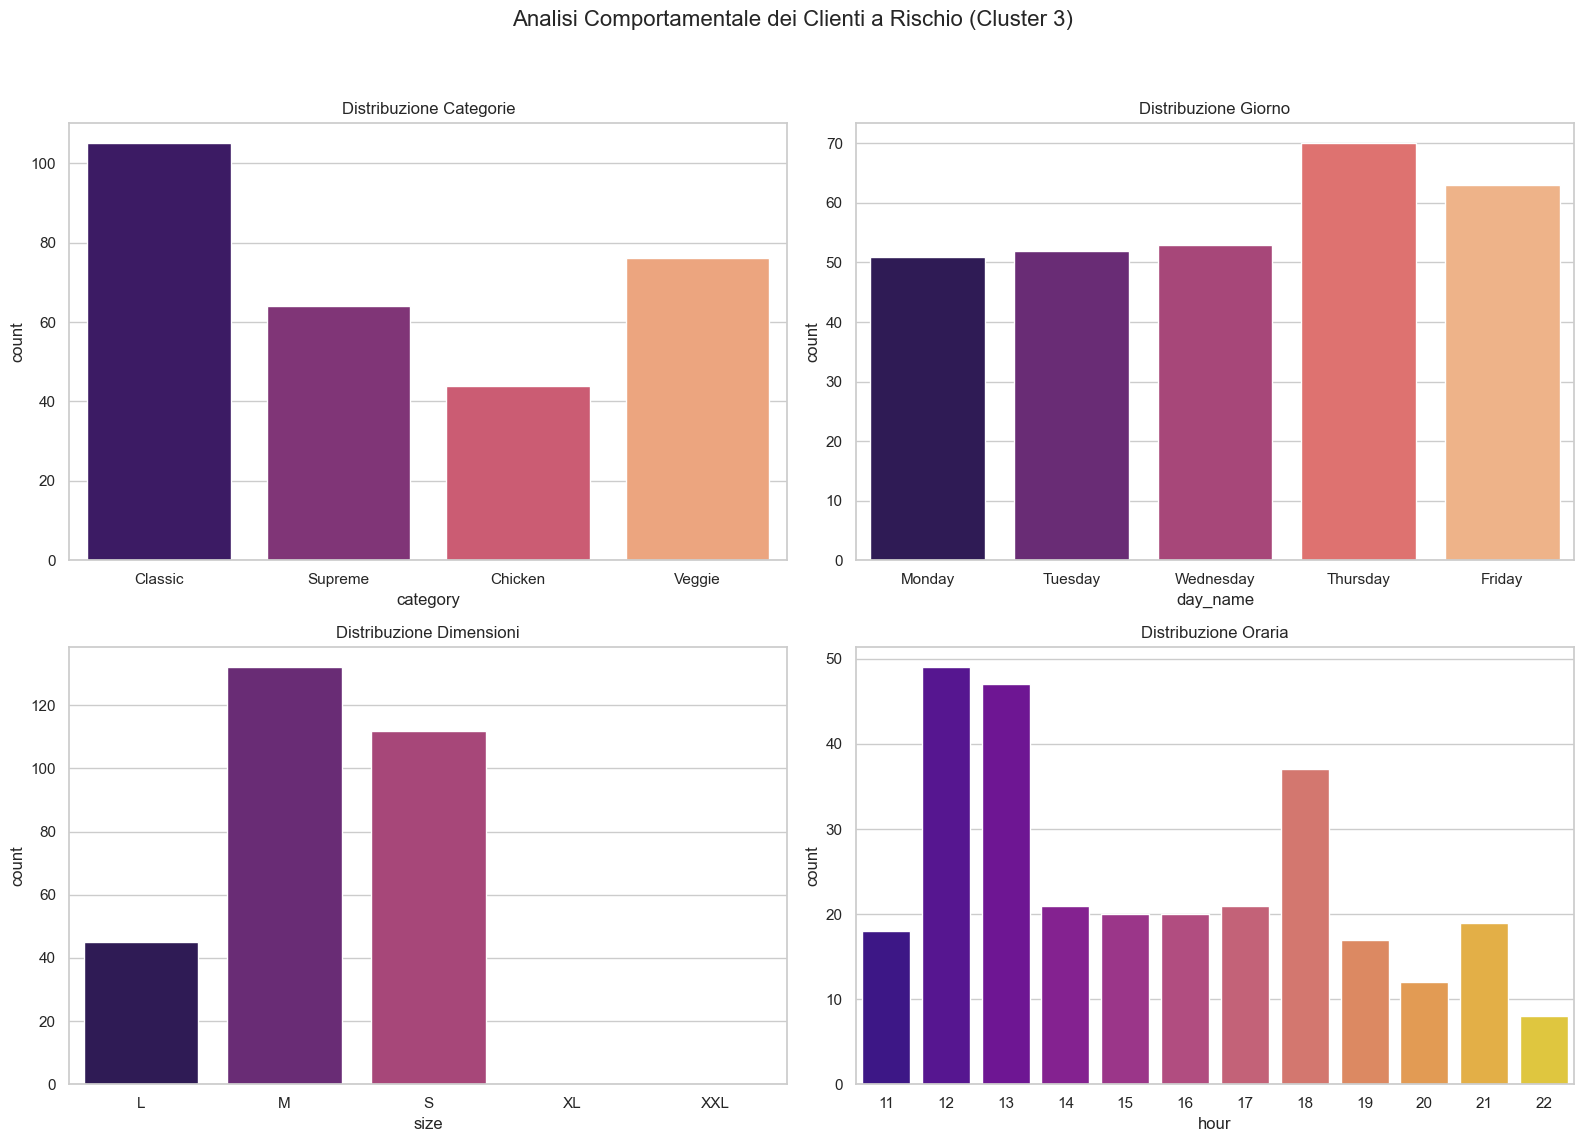

In [17]:
# ---------------------------------------------------------
# --- SEZIONE 6: Analisi Visiva Comportamento Cluster 3 ---
# ---------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Comportamentale dei Clienti a Rischio (Cluster 3)', fontsize=16)
# Categoria
sns.countplot(ax=axes[0, 0], data=risk_cluster_3_df, x='category', order=risk_cluster_4_df['category'].value_counts().index, palette='magma')
axes[0, 0].set_title('Distribuzione Categorie')
# Giorno
sns.countplot(ax=axes[0, 1], data=risk_cluster_3_df, x='day_name', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], palette='magma')
axes[0, 1].set_title('Distribuzione Giorno')
# Dimensione
sns.countplot(ax=axes[1, 0], data=risk_cluster_3_df, x='size', order=risk_cluster_4_df['size'].value_counts().index, palette='magma')
axes[1, 0].set_title('Distribuzione Dimensioni')
# Orario
sns.countplot(ax=axes[1, 1], data=risk_cluster_3_df, x='hour', palette='plasma')
axes[1, 1].set_title('Distribuzione Oraria')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### 6.3 Indagine sul Cluster 2: L'Enigma dell'"Esperienza Weekend"

Infine, l'analisi del Cluster 2 ("Famiglie/Gruppi del Weekend") conferma un profilo eterogeneo, con una prevalenza di gruppi e clienti ad alto reddito, e un consumo concentrato nella fascia oraria della cena.

In [18]:
# --- Statistiche Demografiche Cluster 2 ---
print("--- Profilo Demografico (Cluster 2) ---")
display(risk_cluster_2_df.describe(include=['object']))

--- Profilo Demografico (Cluster 2) ---


,pizza_id,pizza_type_id,size,name,category,ingredients,customer_id,day_name,persona,income_bracket
count,818,818,818,818,818,818,818,818,818,818
unique,91,32,5,32,4,32,397,2,3,3
top,big_meat_s,cali_ckn,L,The California Chicken Pizza,Classic,"Chicken, Artichoke, Spinach, Garlic, Jalapeno ...",cust_5982,Saturday,Family/Groups,High
freq,26,42,301,42,228,42,5,471,450,368


L'analisi delle loro scelte di pizza, visualizzata nella tabella sottostante, ha permesso di **escludere l'ipotesi di un problema legato al prodotto**. Le loro preferenze sono risultate del tutto in linea con quelle dei clienti più fedeli.

In [19]:
# --- Analisi Pizze Ordinate (Cluster 2 vs. Fedeli) ---
top_20_pizzas_cluster_2 = risk_cluster_2_df['name'].value_counts(normalize=True).nlargest(20) * 100
comparison_pizzas_c2_df = pd.DataFrame({'Clienti a Rischio (Cluster 2) %': top_20_pizzas_cluster_2, 'Clienti Fedeli %': top_pizzas_loyal}).fillna(0)
print("\n--- Confronto Top 20 Pizze Ordinate (Cluster 2 vs. Fedeli) ---")
display(comparison_pizzas_c2_df)


--- Confronto Top 20 Pizze Ordinate (Cluster 2 vs. Fedeli) ---


,Clienti a Rischio (Cluster 2) %,Clienti Fedeli %
name,,
The Barbecue Chicken Pizza,4.52,4.88
The Big Meat Pizza,3.18,0.00
The California Chicken Pizza,5.13,4.79
The Classic Deluxe Pizza,4.65,4.93
The Five Cheese Pizza,2.81,0.00
The Four Cheese Pizza,3.18,3.82
The Hawaiian Pizza,4.65,4.87
The Italian Supreme Pizza,3.67,0.00
The Mexicana Pizza,3.06,0.00


**Conclusione per il Cluster 2**: L'abbandono di questo segmento non sembra essere causato da ciò che ordinano, ma dal **contesto in cui lo ordinano**. La loro esperienza negativa è probabilmente legata a fattori operativi o ambientali specifici del weekend, che si allineano con la generale debolezza delle vendite domenicali già evidenziata nell'EDA.

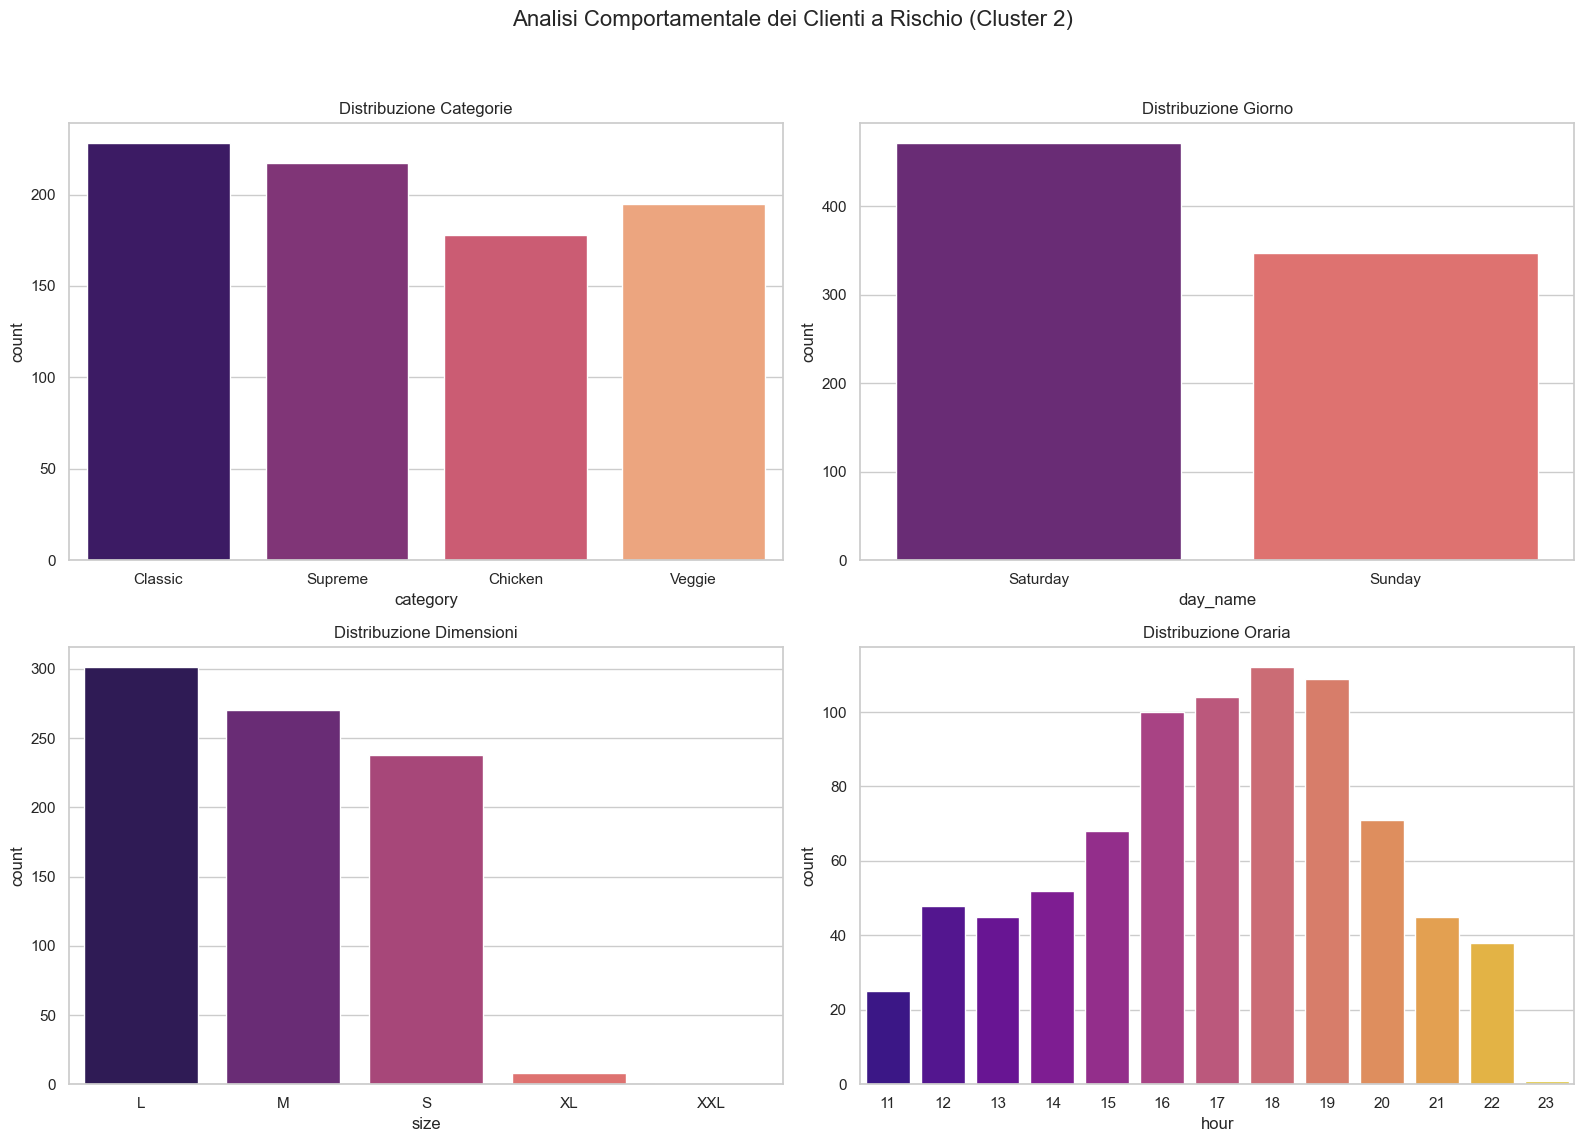

In [20]:
# ---------------------------------------------------------
# --- SEZIONE 6: Analisi Visiva Comportamento Cluster 2 ---
# ---------------------------------------------------------

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisi Comportamentale dei Clienti a Rischio (Cluster 2)', fontsize=16)
# Categoria
sns.countplot(ax=axes[0, 0], data=risk_cluster_2_df, x='category', order=risk_cluster_4_df['category'].value_counts().index, palette='magma')
axes[0, 0].set_title('Distribuzione Categorie')
# Giorno
sns.countplot(ax=axes[0, 1], data=risk_cluster_2_df, x='day_name', order=['Saturday', 'Sunday'], palette='magma')
axes[0, 1].set_title('Distribuzione Giorno')
# Dimensione
sns.countplot(ax=axes[1, 0], data=risk_cluster_2_df, x='size', order=risk_cluster_4_df['size'].value_counts().index, palette='magma')
axes[1, 0].set_title('Distribuzione Dimensioni')
# Orario
sns.countplot(ax=axes[1, 1], data=risk_cluster_2_df, x='hour', palette='plasma')
axes[1, 1].set_title('Distribuzione Oraria')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 7. Conclusioni e Raccomandazioni Strategiche <a id='conclusioni'></a>

L'intero ciclo di analisi, dalla pulizia dei dati all'indagine investigativa, ci ha permesso di trasformare un'ampia mole di dati transazionali in una mappa strategica chiara della clientela. Le conclusioni seguenti riassumono la struttura finale del mercato, che costituisce la base per le raccomandazioni operative presentate di seguito.

### 7.1 Mappa Finale dei Segmenti di Mercato

L'analisi ha rivelato una base clienti suddivisa in **quattro macro-segmenti strategici**, con la seguente distribuzione:

* **Il Nucleo Mainstream (54%):** Il cuore del business, composto da clienti occasionali (1-3 visite/anno) con profili eterogenei. Su di loro si regge il volume d'affari quotidiano. (Cluster 4,5,6,7,8,9)
* **I Clienti Fedeli (25%):** Il patrimonio più prezioso dell'azienda in termini di CLV, grazie alla loro altissima frequenza di acquisto (4+ visite/anno). Rappresentano la base di fatturato più stabile e prevedibile. (Cluster 0,1,10)
* **I Clienti a Rischio Abbandono (9%):** Un segmento critico di clienti "mono-visita", la cui analisi ha rivelato due problematiche distinte: una legata all'esperienza generale del weekend e una all'offerta di prodotti entry-level. (Cluster 2,3)
* **Gli Outlier (11%):** Clienti con profili di comportamento unici ed estremi, non appartenenti a un segmento strategico definito.

### 7.2 Raccomandazioni Strategiche

Basandosi sulla mappa dei segmenti, si formulano le seguenti raccomandazioni in ordine di priorità.

#### Raccomandazione 1: Proteggere e Valorizzare i "Clienti Fedeli" (Alta Priorità)

**Il Problema**: Il segmento dei "Clienti Fedeli" (25% della clientela) rappresenta la spina dorsale del fatturato ricorrente. La loro perdita avrebbe un impatto sproporzionato sul business a lungo termine (alto CLV).

**L'Azione Consigliata**: Lanciare un **programma fedeltà** strutturato. L'obiettivo non è incentivare la spesa per visita (già stabile), ma premiare e consolidare la loro routine d'acquisto.
* **Esempio Tattico**: Una classica "stamp card" (fisica o digitale) con la formula "Ogni 10 pizze, la prossima è in omaggio". Questo rafforza l'abitudine e crea una barriera all'ingresso per i competitor.

#### Raccomandazione 2: Intervenire sui "Clienti a Rischio Abbandono" (Alta Priorità)

**Il Problema**: Il 9% dei nuovi clienti non torna dopo la prima visita, con due cause principali identificate.

**Le Azioni Consigliate**:
1.  **Revisione del Menu Entry-Level (per il Cluster 3)**: L'indagine ha rivelato che i nuovi clienti a basso budget (Studenti/Professionisti) hanno una probabilità significativa (circa il 13%) di ordinare una delle 5 pizze meno popolari del menu, vivendo un'esperienza potenzialmente deludente.
    * **Esempio Tattico**: Rivedere le ricette di queste 5 pizze o sostituirle con opzioni entry-level più semplici ma di sicura riuscita. Assicurarsi che anche la pizza più economica offra un'esperienza qualitativa impeccabile è fondamentale per non "avvelenare" il primo contatto con il brand.
2.  **Analisi Strategica dell'Esperienza Weekend (per il Cluster 2)**: L'abbandono dei clienti del weekend non è legato al prodotto, ma probabilmente a fattori operativi o ambientali.
    * **Esempio Tattico**: Avviare un'analisi qualitativa mirata sul fine settimana: monitorare i tempi medi di attesa, raccogliere feedback diretti sul servizio, analizzare le offerte della concorrenza locale attiva nel weekend, specialmente per la domenica.

#### Raccomandazione 3: Aumentare la Profittabilità del "Nucleo Mainstream" (Media Priorità)

**Il Problema**: Il "Nucleo Mainstream" (54% dei clienti) rappresenta un enorme volume di clienti occasionali con uno scontrino medio che ha ampi margini di crescita.

**L'Azione Consigliata**: Implementare strategie di **upselling e cross-selling a basso impatto** per aumentare il valore di ogni transazione senza spaventare una clientela sensibile al prezzo.
* **Esempi Tattici**: Creare "Menu Combo" vantaggiosi (es. pizza + bibita a prezzo speciale), istruire il personale a proporre attivamente prodotti complementari (dolci, antipasti), lanciare promozioni a tempo limitato su prodotti specifici.

#### Raccomandazione 4: Sfruttare il Potenziale Inespresso della Domenica (Media Priorità)

**Il Problema**: L'EDA ha mostrato che la domenica è il giorno della settimana con il minor numero di ordini, un'anomalia per il settore della pizza.

**L'Azione Consigliata**: Creare una **campagna di marketing specifica per la domenica** per trasformare una debolezza in un'opportunità.
* **Esempio Tattico**: Lanciare un'offerta "Domenica in Famiglia" (es. 2 pizze classiche + bibita grande a prezzo fisso) per attrarre il segmento "Family/Groups", attualmente poco attivo in quel giorno.

## 8. Limiti dell'Analisi e Sviluppi Futuri <a id='limiti'></a>

Questo progetto ha fornito una mappa strategica dettagliata della clientela, ma è importante riconoscerne i limiti intrinseci e delineare le direzioni future che potrebbero generare ancora più valore.

### 8.1 Limiti dell'Analisi Corrente

La validità delle nostre conclusioni è soggetta a tre limitazioni principali:

1.  **Natura dei Dati Demografici**: La limitazione più significativa è l'uso di dati demografici **sintetici**. Sebbene l'approccio basato su regole sia logico e data-driven, rimane una simulazione del comportamento reale. L'accesso a dati anagrafici reali (raccolti tramite programmi fedeltà o sondaggi) fornirebbe profili indubbiamente più accurati.

2.  **Orizzonte Temporale dei Dati**: L'analisi si basa su un **singolo anno** di transazioni. Questo non permette di confermare con certezza statistica i pattern di stagionalità osservati né di analizzare le tendenze di crescita o decrescita del business nel lungo periodo.

3.  **Assenza di Dati Qualitativi**: L'analisi è puramente quantitativa, basata sul comportamento d'acquisto. Manca una dimensione qualitativa (es. recensioni online, sondaggi di soddisfazione) che potrebbe spiegare il "perché" dietro alcuni pattern, in particolare le cause profonde dell'abbandono dei "Clienti a Rischio".

### 8.2 Sviluppi Futuri Raccomandati

Sulla base di questa analisi, si raccomandano i seguenti sviluppi futuri per approfondire la comprensione del mercato e ottimizzare le operazioni:

1.  **Analisi Predittiva delle Preferenze**: Il dataset arricchito che abbiamo costruito è la base perfetta per un secondo progetto focalizzato sulla **classificazione**. Si potrebbe addestrare un modello (es. **Albero Decisionale, Random Forest**) per predire la categoria di pizza preferita da un nuovo cliente in base al suo profilo, abilitando strategie di marketing personalizzato in tempo reale.

2.  **Forecasting della Domanda per l'Ottimizzazione Operativa**: L'EDA ha rivelato pattern di vendita giornalieri e orari molto chiari. Un passo successivo di grande valore sarebbe lo sviluppo di un **modello di forecasting delle serie storiche (es. SARIMA)** per prevedere il volume di ordini su base giornaliera. Questo permetterebbe un'ottimizzazione data-driven della gestione del personale e dell'inventario, riducendo i costi e gli sprechi.

3.  **Generazione Avanzata di Dati Sintetici**: Per migliorare ulteriormente la robustezza dei profili cliente in assenza di dati reali, una futura iterazione potrebbe esplorare l'uso di piattaforme di **Generative AI come Mostly AI**. Questo permetterebbe di creare un dataset sintetico che preserva le complesse correlazioni statistiche dei dati originali in modo più sofisticato.

4.  **Validazione tramite A/B Testing**: Tutte le raccomandazioni strategiche che implicano un cambiamento (es. modifiche al menu, nuove promozioni) dovrebbero essere validate attraverso **A/B test controllati** prima di un'implementazione su larga scala, al fine di misurarne l'impatto reale e minimizzare i rischi.